In [3]:
import pandas as pd
import numpy as np
from numpy.random import randn
from math import radians, sin, cos, sqrt, asin
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

In [3]:
data = pd.read_csv('data/CreditCardFraudFourYears.csv')

In [4]:
data.head()

,Unnamed: 0,ssn,cc_num,first,last,gender,street,city,state,zip,...,trans_num,trans_date,trans_time,unix_time,category,amt,is_fraud,merchant,merch_lat,merch_long
0,0,765-75-7020,3553287101226916,James,Carlson,M,480 Erin Plain Suite 514,Wilmington,DE,19802,...,79fc4fa0f0cd9659311b2d49cfe4a4fc,2019-11-07,03:40:47,1573116047,grocery_pos,339.80,1,fraud_Bradtke PLC,39.817013,-76.261575
1,1,765-75-7020,3553287101226916,James,Carlson,M,480 Erin Plain Suite 514,Wilmington,DE,19802,...,49b27f2afa61b46b0b32f7788e36b153,2019-11-08,14:34:29,1573241669,shopping_net,748.51,1,"fraud_Greenholt, O'Hara and Balistreri",39.035818,-75.712679
2,2,765-75-7020,3553287101226916,James,Carlson,M,480 Erin Plain Suite 514,Wilmington,DE,19802,...,31be259a3847db1be7fcfd13fd25d8ae,2019-11-08,22:03:19,1573268599,shopping_net,884.03,1,fraud_Predovic Inc,40.257706,-75.481461
3,3,765-75-7020,3553287101226916,James,Carlson,M,480 Erin Plain Suite 514,Wilmington,DE,19802,...,51d314e70aaf8232a2bca4890521b2bc,2019-11-08,21:24:31,1573266271,misc_net,1112.76,1,fraud_Kunde-Sanford,40.724499,-74.890105
4,4,765-75-7020,3553287101226916,James,Carlson,M,480 Erin Plain Suite 514,Wilmington,DE,19802,...,6036ba37cc66f5d9490889b44497a50b,2019-11-08,22:12:36,1573269156,travel,1059.24,1,"fraud_Champlin, Rolfson and Connelly",38.999529,-75.765187


In [9]:
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar

df = data.copy(deep=True)

df['trans_date'] = df['trans_date'].astype(str)
df['trans_time'] = df['trans_time'].astype(str)

df['trans_datetime'] = df['trans_date'] + ' ' + df['trans_time']

df['trans_datetime'] = pd.to_datetime(df['trans_datetime'])
df['trans_date'] = pd.to_datetime(df['trans_date'])
df['hour'] = df['trans_datetime'].dt.hour

days_map = {'Monday': 1, 'Tuesday': 2, 'Wednesday': 3, 'Thursday': 4, 'Friday': 5, 'Saturday': 6, 'Sunday': 7}
df['day_of_week'] = df['trans_date'].dt.day_name().map(days_map)

df['month'] = df['trans_date'].dt.month

df['weekday_vs_weekend'] = df['trans_datetime'].dt.dayofweek.apply(lambda x: 0 if x < 5 else 1)

categorical_columns = ['hour']
df = pd.get_dummies(df, columns=categorical_columns)

cal = calendar()
holidays = cal.holidays(start=df['trans_datetime'].min(), end=df['trans_datetime'].max())
df['is_public_holiday'] = df['trans_datetime'].dt.normalize().isin(holidays)

transaction_counts = df['cc_num'].value_counts().to_dict()
df['activity_level'] = df['cc_num'].map(transaction_counts)

first_payday = pd.Timestamp('2014-12-19')
paydays = pd.date_range(start=first_payday, end=df['trans_datetime'].max(), freq='2W-FRI')
df['is_payday'] = df['trans_datetime'].dt.date.astype('datetime64[ns]').isin(paydays.date)

daily_totals = df.groupby('trans_date').size().rename('total_daily_transactions')
daily_fraud_totals = df.groupby('trans_date')['is_fraud'].sum().rename('total_daily_fraud_transactions')

hourly_columns = ['hour_' + str(i) for i in range(24)]
daily_hourly_totals = df.groupby('trans_date')[hourly_columns].sum()

daily_data = pd.DataFrame(daily_totals).join(daily_fraud_totals)
daily_data = daily_data.merge(daily_hourly_totals, on='trans_date', how='left')
daily_features = df.groupby('trans_date')[['day_of_week', 'month', 'weekday_vs_weekend']].first()

daily_data['is_public_holiday'] = df.groupby('trans_date')['is_public_holiday'].max()
daily_data['activity_level'] = df.groupby('trans_date')['activity_level'].mean()
daily_data['is_payday'] = df.groupby('trans_date')['is_payday'].max()
daily_data = daily_data.join(daily_features)

daily_data.reset_index(inplace=True)

daily_data.set_index('trans_date', inplace=True)

daily_data.head(15)

,total_daily_transactions,total_daily_fraud_transactions,hour_0,hour_1,hour_2,hour_3,hour_4,hour_5,hour_6,hour_7,...,hour_20,hour_21,hour_22,hour_23,is_public_holiday,activity_level,is_payday,day_of_week,month,weekday_vs_weekend
trans_date,,,,,,,,,,,,,,,,,,,,,
2018-01-01,1016,0,89,88,97,76,82,82,73,95,...,0,0,0,0,False,6070.808071,False,1,1,0
2018-01-02,1193,0,101,116,107,105,89,110,90,85,...,0,0,0,0,False,6165.922883,False,2,1,0
2018-01-03,1131,0,77,96,91,98,83,106,92,96,...,0,0,0,0,False,6084.626879,False,3,1,0
2018-01-04,1170,0,72,106,95,106,105,99,121,93,...,0,0,0,0,False,6034.745299,False,4,1,0
2018-01-05,1851,7,150,159,153,134,140,152,155,152,...,0,0,0,1,False,6116.927607,False,5,1,0


In [11]:
daily_data.head(15)

,total_daily_transactions,total_daily_fraud_transactions,hour_0,hour_1,hour_2,hour_3,hour_4,hour_5,hour_6,hour_7,...,hour_20,hour_21,hour_22,hour_23,is_public_holiday,activity_level,is_payday,day_of_week,month,weekday_vs_weekend
trans_date,,,,,,,,,,,,,,,,,,,,,
2018-01-01,1016,0,89,88,97,76,82,82,73,95,...,0,0,0,0,False,6070.808071,False,1,1,0
2018-01-02,1193,0,101,116,107,105,89,110,90,85,...,0,0,0,0,False,6165.922883,False,2,1,0
2018-01-03,1131,0,77,96,91,98,83,106,92,96,...,0,0,0,0,False,6084.626879,False,3,1,0
2018-01-04,1170,0,72,106,95,106,105,99,121,93,...,0,0,0,0,False,6034.745299,False,4,1,0
2018-01-05,1851,7,150,159,153,134,140,152,155,152,...,0,0,0,1,False,6116.927607,False,5,1,0
2018-01-06,2149,28,183,179,211,179,162,179,149,181,...,0,1,6,7,False,6153.966961,False,6,1,1
2018-01-07,2131,14,178,160,183,201,169,154,168,185,...,0,1,3,9,False,6119.175974,False,7,1,1
2018-01-08,942,0,74,73,69,87,80,81,79,95,...,0,0,0,0,False,6213.901274,False,1,1,0
2018-01-09,1077,5,84,104,86,83,83,96,88,87,...,0,0,0,0,False,6074.615599,False,2,1,0


In [22]:
df.sort_values('trans_datetime', inplace=True)

split_idx = int(len(df) * 0.8)

split_date = df.iloc[split_idx]['trans_datetime']
print(split_date)

2022-01-01 18:26:49


In [23]:
from sklearn.model_selection import train_test_split

split_date = pd.Timestamp('2022-01-01 18:26:49')

train = df[df['trans_datetime'] <= split_date]
test = df[df['trans_datetime'] > split_date]

train_info = (train['trans_datetime'].min(), train['trans_datetime'].max(), len(train))
test_info = (test['trans_datetime'].min(), test['trans_datetime'].max(), len(test))

print(train_info, test_info)

train = df[df['trans_datetime'] <= split_date]
test = df[df['trans_datetime'] > split_date]

print(f'Training set range: {train["trans_datetime"].min()} to {train["trans_datetime"].max()}')
print(f'Test set range: {test["trans_datetime"].min()} to {test["trans_datetime"].max()}')
print(f'Training set size: {len(train)}')
print(f'Test set size: {len(test)}')
train.head()

(Timestamp('2018-01-01 00:00:18'), Timestamp('2022-01-01 18:26:49'), 3204454) (Timestamp('2022-01-01 18:27:34'), Timestamp('2022-12-31 23:59:49'), 801113)
Training set range: 2018-01-01 00:00:18 to 2022-01-01 18:26:49
Test set range: 2022-01-01 18:27:34 to 2022-12-31 23:59:49
Training set size: 3204454
Test set size: 801113


,is_fraud,trans_datetime,hour,day_of_week,month,weekday_vs_weekend,part_of_day,is_public_holiday,activity_level,is_payday
1994196,0,2018-01-01 00:00:18,0,Monday,January,Weekday,Night,False,9128,False
222406,0,2018-01-01 00:00:31,0,Monday,January,Weekday,Night,False,5479,False
633920,0,2018-01-01 00:01:08,0,Monday,January,Weekday,Night,False,1833,False
2551993,0,2018-01-01 00:01:09,0,Monday,January,Weekday,Night,False,3660,False
59570,0,2018-01-01 00:01:50,0,Monday,January,Weekday,Night,False,5473,False


In [24]:
df['trans_datetime'] = pd.to_datetime(df['trans_datetime'])
df.set_index('trans_datetime', inplace=True)

daily_transactions = df.resample('M').size()  

In [51]:
train['trans_datetime'] = pd.to_datetime(train['trans_datetime'])
train.set_index('trans_datetime', inplace=True)
train_monthly = train.resample('M').size()

In [50]:
test['trans_datetime'] = pd.to_datetime(test['trans_datetime'])
test.set_index('trans_datetime', inplace=True)
test_monthly = test.resample('M').size()


KeyError: 'trans_datetime'

In [52]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(train_monthly)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])


ADF Statistic: -2.567135
p-value: 0.099982


In [ ]:
p, d, q = 0,1,3
P, D, Q, m = 1,0,1,12 

In [53]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(train_monthly,
                order=(p, d, q),
                seasonal_order=(P, D, Q, m))
results = model.fit()

print(results.summary())

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                   49
Model:             SARIMAX(0, 1, 3)x(1, 0, [1], 12)   Log Likelihood                -545.025
Date:                              Wed, 03 Apr 2024   AIC                           1102.049
Time:                                      16:47:13   BIC                           1113.277
Sample:                                  01-31-2018   HQIC                          1106.292
                                       - 01-31-2022                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -1.0417      0.302     -3.445      0.001      -1.634      -0.449
ma.L2          0.12

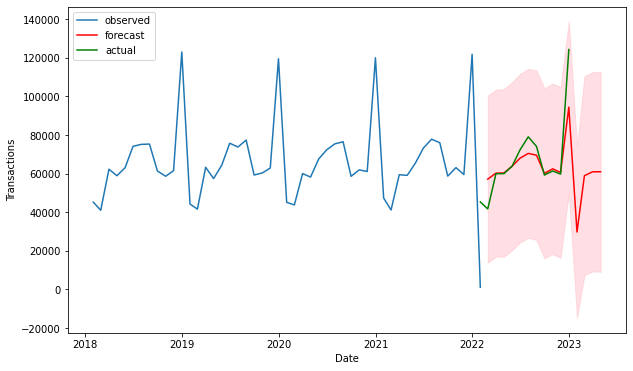

In [56]:
forecast = results.get_forecast(steps=15)
mean_forecast = forecast.predicted_mean
conf_int = forecast.conf_int()


import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(train_monthly.index.to_pydatetime(), train_monthly.values, label='observed')

plt.plot(mean_forecast.index.to_pydatetime(), mean_forecast.values, color='r', label='forecast')

plt.plot(test_monthly.index.to_pydatetime(), test_monthly.values, color='g', label='actual')

plt.fill_between(mean_forecast.index.to_pydatetime(), conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='pink', alpha=0.5)

plt.xlabel('Date')
plt.ylabel('Transactions')
plt.legend()
plt.show()

In [ ]:
data = pd.read_csv('data/CreditCardFraudFourYears.csv')

In [ ]:
from data_pipeline import Pipeline

In [ ]:
pipeline = Pipeline()
transformed_df = pipeline.transform(df)

In [6]:
from sklearn.preprocessing import MinMaxScaler


In [1]:
from tensorflow.keras.models import load_model

# Load the model
model = load_model('finalDeepModel') 

2024-04-06 15:41:15.046684: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [13]:
from joblib import load
scaler_x = load('finalDeepModel/scaler_x.joblib')
scaler_y = load('finalDeepModel/scaler_y.joblib')


In [30]:
input_date = '2024-08-02' 
input_date = pd.to_datetime(input_date)

sequence_length = 12

sequence_dates = [(input_date - pd.Timedelta(days=x)).strftime('%m/%d') for x in range(sequence_length)]


historical_df = pd.read_csv('average_daily_data.csv')

forecast_input_df = historical_df[historical_df['mm_dd'].isin(sequence_dates)]

historical_df.drop('mm_dd', axis=1, inplace=True)
forecast_input_df.drop('mm_dd', axis=1, inplace=True)
historical_df.drop('total_daily_transactions', axis=1, inplace=True)
forecast_input_df.drop('total_daily_transactions', axis=1, inplace=True)
historical_df.drop('total_daily_fraud_transactions', axis=1, inplace=True)
forecast_input_df.drop('total_daily_fraud_transactions', axis=1, inplace=True)

forecast_input_scaled = scaler_x.transform(forecast_input_df)

forecast_input_reshaped = forecast_input_scaled.reshape((forecast_input_scaled.shape[0], 1, forecast_input_scaled.shape[1]))

forecast_input_values = forecast_input_reshaped.astype('float32')


predicted_outcomes = model.predict(forecast_input_values)

predicted_outcomes_rescaled = scaler_y.inverse_transform(predicted_outcomes)

print(f"Predicted Total Transactions: {predicted_outcomes_rescaled[0, 0]}")
print(f"Predicted Fraudulent Transactions: {predicted_outcomes_rescaled[0, 1]}")

1/1 [==============================] - 0s 20ms/step
Predicted Total Transactions: 2397.910400390625
Predicted Fraudulent Transactions: 12.752774238586426


/tmp/ipykernel_734/1596603472.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  forecast_input_df.drop('mm_dd', axis=1, inplace=True)
/tmp/ipykernel_734/1596603472.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  forecast_input_df.drop('total_daily_transactions', axis=1, inplace=True)
/tmp/ipykernel_734/1596603472.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  forecast_input_df.drop('total_daily_fraud_transactions', axis=1

In [1]:
from model import Model
deep_model = Model()

2024-04-06 16:34:34.070754: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
input_date = '2024-08-02' 
notfraud, fraud = deep_model.prediction(input_date)

OutOfBoundsDatetime: Out of bounds nanosecond timestamp: 08-02, at position 0

In [3]:
print(notfraud, fraud)

2397.9104 12.752774


In [5]:
!pip show tensorflow

Name: tensorflow
Version: 2.13.1
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /usr/local/lib/python3.8/dist-packages
Requires: absl-py, astunparse, flatbuffers, gast, google-pasta, grpcio, h5py, keras, libclang, numpy, opt-einsum, packaging, protobuf, setuptools, six, tensorboard, tensorflow-estimator, tensorflow-io-gcs-filesystem, termcolor, typing-extensions, wrapt
Required-by: nvtx-plugins
